In [1]:
import pandas as pd
import numpy as np
import time
import operator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss, f1_score, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
trn = pd.read_csv("../input/train_clean.csv")
target = pd.read_csv("../input/train.csv", usecols=["target"])
tst = pd.read_csv("../input/test_clean.csv")
test_id = tst["ncodpers"]
tst.drop(["ncodpers"], axis=1, inplace=True)
trn.drop(["ncodpers"], axis=1, inplace=True)

print(trn.shape, target.shape, tst.shape)

(45619, 22) (45619, 1) (929615, 22)


In [3]:
print(trn.info(), target.info(), tst.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45619 entries, 0 to 45618
Data columns (total 22 columns):
fecha_dato               45619 non-null object
ind_empleado             45619 non-null object
pais_residencia          45619 non-null object
sexo                     45619 non-null object
age                      45619 non-null int64
fecha_alta               45619 non-null object
ind_nuevo                45619 non-null int64
antiguedad               45619 non-null int64
indrel                   45619 non-null int64
ult_fec_cli_1t           45619 non-null object
indrel_1mes              45619 non-null int64
tiprel_1mes              45619 non-null object
indresi                  45619 non-null object
indext                   45619 non-null object
conyuemp                 45619 non-null object
canal_entrada            45619 non-null object
indfall                  45619 non-null object
cod_prov                 45619 non-null int64
nomprov                  45619 non-null object
ind_

In [4]:
trn.columns == tst.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

In [5]:
for col in trn.columns:
    if trn[col].dtype == "object":
        print(col)

fecha_dato
ind_empleado
pais_residencia
sexo
fecha_alta
ult_fec_cli_1t
tiprel_1mes
indresi
indext
conyuemp
canal_entrada
indfall
nomprov
segmento


In [6]:
for col in trn.columns:
    if trn[col].dtype == "object":
        lb = LabelEncoder()
        lb.fit(pd.concat([trn[col], tst[col]]))
        trn[col] = lb.transform(trn[col])
        tst[col] = lb.transform(tst[col])

In [7]:
for col in trn.columns:
    print(col, trn[col].dtype, tst[col].dtype)

fecha_dato int64 int64
ind_empleado int64 int64
pais_residencia int64 int64
sexo int64 int64
age int64 int64
fecha_alta int64 int64
ind_nuevo int64 int64
antiguedad int64 int64
indrel int64 int64
ult_fec_cli_1t int64 int64
indrel_1mes int64 int64
tiprel_1mes int64 int64
indresi int64 int64
indext int64 int64
conyuemp int64 int64
canal_entrada int64 int64
indfall int64 int64
cod_prov int64 int64
nomprov int64 int64
ind_actividad_cliente int64 int64
renta float64 float64
segmento int64 int64


In [8]:
for t in np.unique(target):
    print(t, sum(target["target"]==t))

2 9452
3 9
4 1934
5 55
6 349
7 222
8 154
9 503
10 33
11 1085
12 1219
13 246
14 4
15 21
16 8
17 2942
18 4733
19 159
20 3
21 5151
22 8218
23 9119


In [9]:
# 빈도가 적은 데이터 제거

In [10]:
rem_targets = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23]  # 18 classes
trn = trn[target["target"].isin(rem_targets)]
target = target[target["target"].isin(rem_targets)]
target = LabelEncoder().fit_transform(target)

C:\Users\Byeon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
# target["target"].isin

In [14]:
def evaluate(x, y, model):
    trn_scores = dict(); vld_scores = dict()
    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=777)
    for t_ind, v_ind in sss.split(x,y):
        # split data
        x_trn, x_vld = x.iloc[t_ind], x.iloc[v_ind]
        y_trn, y_vld = y[t_ind], y[v_ind]

        # fit model
        model.fit(x_trn, y_trn)
        
        # eval _ trn
        preds = model.predict(x_trn)
        acc_scores = trn_scores.get('accuracy', [])
        acc_scores.append(accuracy_score(y_trn, preds))
        trn_scores['accuracy'] = acc_scores

        f1_scores = trn_scores.get('f1 score', [])
        f1_scores.append(f1_score(y_trn, preds, average='weighted'))
        trn_scores['f1 score'] = f1_scores
        
        preds = model.predict_proba(x_trn)

        log_scores = trn_scores.get('log loss', [])
        log_scores.append(log_loss(y_trn, preds))
        trn_scores['log loss'] = log_scores

        # eval _ vld
        preds = model.predict(x_vld)
        acc_scores = vld_scores.get('accuracy', [])
        acc_scores.append(accuracy_score(y_vld, preds))
        vld_scores['accuracy'] = acc_scores

        f1_scores = vld_scores.get('f1 score', [])
        f1_scores.append(f1_score(y_vld, preds, average='weighted'))
        vld_scores['f1 score'] = f1_scores
        
        preds = model.predict_proba(x_vld)

        log_scores = vld_scores.get('log loss', [])
        log_scores.append(log_loss(y_vld, preds))
        vld_scores['log loss'] = log_scores
    return trn_scores, vld_scores

def print_scores(trn_scores, vld_scores):
    prefix = '        '
    cols = ['accuracy', 'f1 score','log loss']
    print('='*50)
    print('TRAIN EVAL')
    for col in cols:
        print('-'*50)
        print('# {}'.format(col))
        print('# {} Mean : {}'.format(prefix, np.mean(trn_scores[col])))
        print('# {} Raw  : {}'.format(prefix, trn_scores[col]))

    print('='*50)
    print('VALID EVAL')
    for col in cols:
        print('-'*50)
        print('# {}'.format(col))
        print('# {} Mean : {}'.format(prefix, np.mean(vld_scores[col])))
        print('# {} Raw  : {}'.format(prefix, vld_scores[col]))

def print_time(end, start):
    print('='*50)
    elapsed = end - start
    print('{} secs'.format(round(elapsed)))
    
def fit_and_eval(trn, target, model):
    trn_scores, vld_scores = evaluate(trn,target,model)
    print_scores(trn_scores, vld_scores)
    print_time(time.time(), st)    

In [15]:
st = time.time()
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs=-1, random_state=777)
fit_and_eval(trn, target, model)
# 58 sec

C:\Users\Byeon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


TRAIN EVAL
--------------------------------------------------
# accuracy
#          Mean : 0.2689817635351935
#          Raw  : [0.26660168149140978, 0.27308395272328501, 0.26725965639088584]
--------------------------------------------------
# f1 score
#          Mean : 0.1935636190100405
#          Raw  : [0.18744667752682029, 0.20518539950478837, 0.18805877999851281]
--------------------------------------------------
# log loss
#          Mean : 2.0239253340972945
#          Raw  : [2.0252648324052274, 2.0237462642254758, 2.0227649056611798]
VALID EVAL
--------------------------------------------------
# accuracy
#          Mean : 0.26622807017543865
#          Raw  : [0.26337719298245615, 0.27543859649122809, 0.25986842105263158]
--------------------------------------------------
# f1 score
#          Mean : 0.19096039754864078
#          Raw  : [0.18323018001326635, 0.20681280442409578, 0.18283820820856014]
--------------------------------------------------
# log loss
#          M

In [25]:
# Utility

def observe_model_lr(model):
    target_num = 0
    print('='*50)
    print(model)
    
    print('='*50)
    print('# Coefficients for target_num == {}'.format(target_num))
    print(model.coef_[target_num])
    
    print('-'*50)
    print('# Mapped to Column Name')
    prefix = '    '
    coefs = dict()
    for i, coef in enumerate(model.coef_[target_num]):
        print('{} {} \t {}'.format(prefix, round(coef,5), trn.columns[i]))
        coefs[trn.columns[i]] = np.absolute(coef)

    print('-'*50)
    print('# Sorted Feature Importance')
    coefs_sorted = sorted(coefs.items(), key=operator.itemgetter(1), reverse=True)
    for item in coefs_sorted:
        print('{} {} \t {}'.format(prefix, round(item[1],5), item[0]))
    
    return coefs_sorted

def plot_coef(coef):
    x = []; y = []
    for item in coef:
        x.append(item[0])
        y.append(item[1])

    f, ax = plt.subplots(figsize=(20, 15))
    sns.barplot(x,y,alpha=0.5)
    ax.set_title('Feature Importance for Model : Logistic Regression')
    ax.set(xlabel='Column Name', ylabel='Feature Importance')

In [26]:
# 모델 상세 보기
coef = observe_model_lr(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=777, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
# Coefficients for target_num == 0
[  0.00000000e+00  -1.44479305e-04  -1.72440483e-03  -6.62831797e-05
  -4.00738642e-03  -1.37587306e-04   9.43799153e-05  -9.75453910e-03
  -4.57973205e-05   1.71631976e-05  -4.77794835e-05   5.31567487e-05
  -9.51667325e-05   1.64720342e-05  -4.82183632e-05   2.95537254e-03
   8.31537519e-07  -1.12444979e-03  -1.08733896e-03  -1.07982690e-04
  -1.84225687e-07   4.04364051e-06]
--------------------------------------------------
# Mapped to Column Name
     0.0 	 fecha_dato
     -0.00014 	 ind_empleado
     -0.00172 	 pais_residencia
     -7e-05 	 sexo
     -0.00401 	 age
     -0.00014 	 fecha_alta
     9e-05 	 ind_nuevo
     -0.00975 	 antiguedad
     -5e-05 	 indrel
     2e-05 	 ult_fec_cli

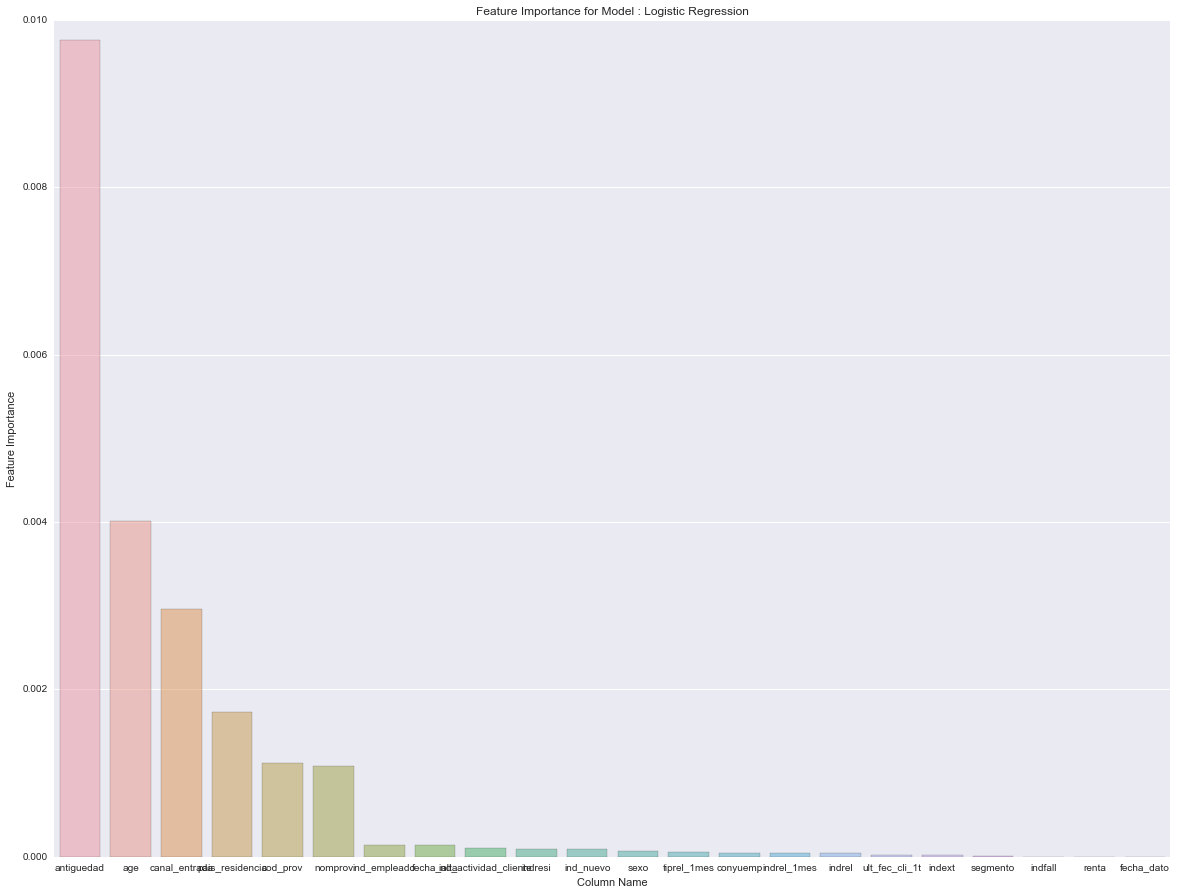

In [27]:
# 주요 변수 시각화
plot_coef(coef)

## 이 상태로 캐글에 업로드하니 1000등^^~~~~~~~~~~~~

모델의 복잡도를 줄여보고, 데이터를 수정해보자

# Feature Engineering 을 해보자

In [29]:
trn.head()

,fecha_dato,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,...,indresi,indext,conyuemp,canal_entrada,indfall,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
0,0,3,36,2,28,5485,0,34,1,0,...,2,0,1,150,0,28,30,1,189517.86,2
1,0,3,36,2,28,5485,0,34,1,0,...,2,0,1,150,0,28,30,1,189517.86,2
2,0,3,36,2,37,5485,0,34,1,0,...,2,0,1,122,0,28,30,1,107894.52,1
3,0,3,36,2,37,5485,0,34,1,0,...,2,0,1,122,0,28,30,1,107894.52,1
4,0,3,36,0,40,5485,0,34,1,0,...,2,0,1,122,0,28,30,1,93847.89,1


In [30]:
trn["age"] = (trn["age"]/10).astype(int)

In [33]:
tst["age"] = (tst["age"]/10).astype(int)

In [ ]:
# indresi, conyuemp, ult_fec_cli_1t 빈도수가 적으니 제거
